# Predicting prices with a single-asset regression model

## ---Preparing the independent and target variables

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install yahoo_fin
!pip install requests_html

     |████████████████████████████████| 153kB 12.4MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 133kB 17.7MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13484 sha256=2e30d1744b38f243ca0c21c6ae1136e9989b91c9d14aaf240bda95e48b5ce4a3
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for parse: filename=parse-1.15.0-cp36-none-any.whl size=23710 sha256=8ed40da215139662eb9a237364c6b30302baed1d0c4e6db4081f43eaab4e539b
  Stored in directory: /root/.cache/pip/wheels/07/ee/c8/eced0759f09fc635398ab1b8e89c38549b28e5db7fd4a53ba5
Successfully built fake-useragent parse
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.9 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is 

Pairs trading is a common statistical arbitrage trading strategy
employed by traders using a pair of co-integrated and highly
positively correlated assets, though negatively correlated pairs
can also be considered.

In this section, we will use machine learning to train
regression-based models using the historical prices of a pair of
securities that might be used in pairs trading. Given the
current price of one security for a particular day, we predict
the other security's price on a daily basis. The following
examples uses the historical daily prices of Goldman Sachs
(GS) and J.P. Morgan (JPM) traded on the New York
Stock Exchange (NYSE). We will be predicting prices of
JPM's stock price for the year 2018

In [ ]:
from yahoo_fin.stock_info import get_data

df_jpm= get_data("JPM",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_gs= get_data("GS",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_gs

,open,high,low,close,adjclose,volume,ticker
1999-05-04,76.000000,77.250000,70.000000,70.375000,55.471191,22320900,GS
1999-05-05,69.875000,69.875000,66.250000,69.125000,54.485905,7565700,GS
1999-05-06,68.000000,69.375000,67.062500,67.937500,53.549885,2905700,GS
1999-05-07,67.937500,74.875000,66.750000,74.125000,58.427040,4862300,GS
1999-05-10,73.375000,73.500000,70.250000,70.687500,55.717506,2589400,GS
...,...,...,...,...,...,...,...
2020-07-15,224.369995,225.240005,214.690002,216.899994,216.899994,12516700,GS
2020-07-16,213.509995,220.460007,213.500000,214.669998,214.669998,5769600,GS
2020-07-17,214.899994,215.169998,211.250000,211.410004,211.410004,3614300,GS
2020-07-20,210.729996,213.169998,210.250000,211.710007,211.710007,2268700,GS


In [ ]:
df_jpm

,open,high,low,close,adjclose,volume,ticker
1980-03-17,0.000000,5.129630,5.018518,5.037037,1.137724,62400,JPM
1980-03-18,0.000000,5.111111,5.037037,5.074074,1.146090,63900,JPM
1980-03-19,0.000000,5.166667,5.111111,5.148148,1.162821,40500,JPM
1980-03-20,0.000000,5.148148,5.092593,5.111111,1.154456,18900,JPM
1980-03-21,0.000000,5.222222,5.111111,5.222222,1.179552,97200,JPM
...,...,...,...,...,...,...,...
2020-07-15,100.889999,101.290001,98.650002,99.730003,99.730003,22508400,JPM
2020-07-16,98.779999,101.220001,98.550003,100.010002,100.010002,16886900,JPM
2020-07-17,100.000000,100.080002,98.139999,98.160004,98.160004,16137700,JPM
2020-07-20,97.430000,98.389999,97.260002,97.300003,97.300003,14458100,JPM


In [ ]:
df_x = pd.DataFrame({'GS': df_gs['adjclose']})
df_x

,GS
1999-05-04,55.471191
1999-05-05,54.485905
1999-05-06,53.549885
1999-05-07,58.427040
1999-05-10,55.717506
...,...
2020-07-15,216.899994
2020-07-16,214.669998
2020-07-17,211.410004
2020-07-20,211.710007


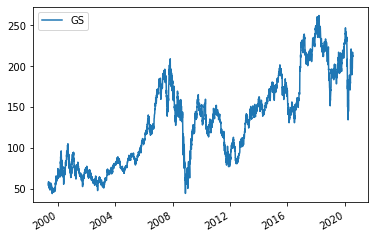

In [ ]:
df_x.plot()

In [ ]:
jpm_prices = df_jpm['adjclose']
jpm_prices

1980-03-17      1.137724
1980-03-18      1.146090
1980-03-19      1.162821
1980-03-20      1.154456
1980-03-21      1.179552
                 ...    
2020-07-15     99.730003
2020-07-16    100.010002
2020-07-17     98.160004
2020-07-20     97.300003
2020-07-21     99.410004
Name: adjclose, Length: 10174, dtype: float64

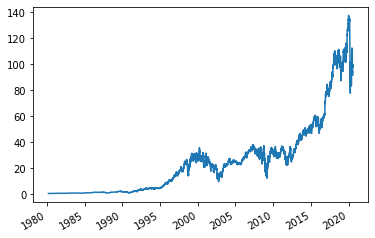

In [ ]:
jpm_prices.plot()

## Writing the linear regression model

Tóm tắt:
Viết chương trình để xác định giá trị cổ phiếu jpm dựa trên giá trị cổ phiếu GS (pair trading). Lấy 20 giá trị trước hiện tại của GS train với 20 giá trị trước hiện tại của jpm, sau đó lấy model này predict giá trị hiện tại jpm dựa trên giá trị hiện tại của GS. model liner sẽ train và predict từng cặp 20 giá trị này cho tới hết data set.

Training set:

x.shape (20, 1)

y.ravel().shape (20,)

X: 20 sample, 1 feature; Y: 20 samples

Khi lấy model này predict bao nhiêu giá trị x thì sẽ có tương ứng bấy nhiêu giá trị y. Ở đây train x và y theo 1-1, tức là chúng ta có linear model của 20 giá trị x theo 20 giá trị y, dùng model này để predict giá trị current

Đây là model sống, nghĩa là model parameter sẽ thay đổi theo mỗi 20 giá trị tiếp theo, sau đó predict giá trị current. Cách train này khá hay , giống với ARIMA

ML thông thường: X (2658,60); Y (2658,) tức là X có 60 features tượng trưng 60 timesteps, 2658 phần tử. Y cũng có 2658 giá trị tương ứng với 2658 giá trị X. Sau khi train hết rồi thì được model, model này sẽ dùng để predict X test (300,60). Đây là model chết do chỉ dùng parameter cũ để predict y theo X, mặc dù X ở đây là giá trị gần với y (30 or 60 ngày gần nhất)

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        print('++def learn')
        print('start_date',start_date)
        print('end_date',start_date)
        print('lookback_period',lookback_period)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            print('----date',date)
            print('x',x)
            print('y',y)
            print('y.ravel()',y.ravel())
            print('x.shape',x.shape)
            print('y.ravel().shape',y.ravel().shape)
            model.fit(x, y.ravel())
            print('model.predict(x)',model.predict(x))
            # Predict the current period
            print('Predict the current period')
            print('date ',date)
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            print('x_current',x_current)
            print('[y_pred]',[y_pred])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            print('y_actual',y_actual)
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        print('++def get_prices_since')
        print('date_since',date_since)
        print('index',index)
        print('index-lookback:index',index-lookback,index) 
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
df_x.head()

,GS
1999-05-04,55.471191
1999-05-05,54.485905
1999-05-06,53.549885
1999-05-07,58.427040
1999-05-10,55.717506


In [ ]:
jpm_prices.head()

1980-03-17    0.287775
1980-03-18    0.289891
1980-03-19    0.294123
1980-03-20    0.292007
1980-03-21    0.298355
Name: adjclose, dtype: float64

In [ ]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                       end_date='2019', lookback_period=20)

Streaming output truncated to the last 5000 lines.
2019-08-26  194.875290
2019-08-27  193.333084
2019-08-28  195.626862
2019-08-29  199.820923
2019-08-30  200.282562
2019-09-03  195.430450
2019-09-04  198.141342
2019-09-05  203.366699
2019-09-06  203.523849
2019-09-09  208.209000
2019-09-10  211.794067
2019-09-11  212.943253
2019-09-12  214.848755
y 2019-08-15    101.641304
2019-08-16    104.076073
2019-08-19    105.013260
2019-08-20    103.679939
2019-08-21    103.969780
2019-08-22    105.042244
2019-08-23    102.433571
2019-08-26    103.254829
2019-08-27    102.163040
2019-08-28    103.187187
2019-08-29    105.525330
2019-08-30    106.143684
2019-09-03    104.887650
2019-09-04    106.153336
2019-09-05    108.568764
2019-09-06    108.800644
2019-09-09    111.496269
2019-09-10    112.916542
2019-09-11    113.225716
2019-09-12    113.921364
Name: adjclose, dtype: float64
y.ravel() [101.64130402 104.07607269 105.01325989 103.67993927 103.96977997
 105.04224396 102.43357086 103.25482941 1

In [ ]:
linear_reg_model.get_model

<bound method LinearRegressionModel.get_model of <__main__.LinearRegressionModel object at 0x7fa543130860>>

In [ ]:
linear_reg_model.df_result

,Actual,Predicted
2018-01-02,99.667267,98.648260
2018-01-03,99.768829,97.747079
2018-01-04,101.198090,99.114569
2018-01-05,100.548431,98.627554
2018-01-08,100.696907,97.197925
...,...,...
2019-12-24,133.990799,134.924558
2019-12-26,135.412704,135.736576
2019-12-27,135.510101,135.478990
2019-12-30,135.013397,135.056242


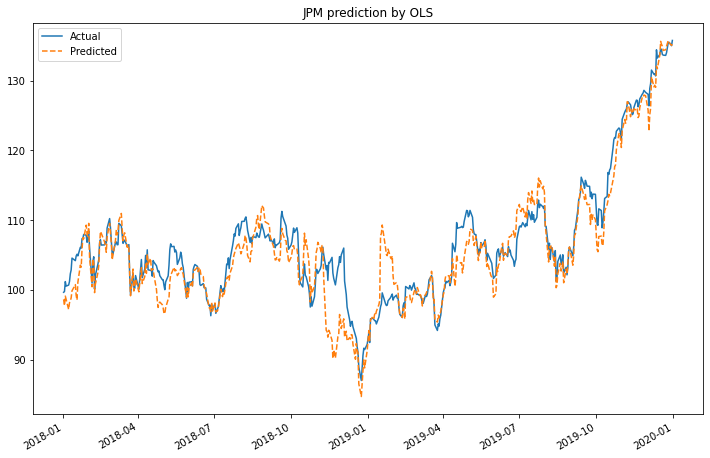

In [ ]:
%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [ ]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 2.122519440928547


#### Mean squared error (MSE) as a risk metric

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

NameError: ignored

### Explained variance score as a risk metric

In [ ]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.8940696578384449


### R<sup>2</sup> as a risk metric

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: 0.8839100940252975


## Ridge regression

### ---set up base class model

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


The ridge regression, or L2 regularization, addresses some of
the problems of OLS regression by penalizing the sum of
squares of the model coefficients

In [ ]:
from sklearn.linear_model import Ridge
# class Ridge kế thừa tất cả thuộc tính của class Linear, chỉ thay đổi get_model method
class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

Here, the α parameter is expected to be a positive value that
controls the amount of shrinkage. Larger values of alpha give
greater shrinkage, making the coefficients more robust to
collinearity

In [ ]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [ ]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [ ]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 1.397926088811901
mean_squared_error: 3.6575413698912453
explained_variance_score: 0.956182511573598
r2_score: 0.9527963519939409


Both mean error scores of the ridge regression model are
lower than the linear regression model and are closer to zero.
The explained variance score and the R score are higher than
the linear regression model and are closer to 1. This indicates
that our ridge regression model is doing a better job of
prediction than the linear regression model. Besides having
better performance, ridge regression computations are less
costly than the original linear regression model.

## ----Check all regression method (DNN):

In [ ]:
from sklearn.pipeline import Pipeline
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
# Creating a list of the classifiers
regression = {

    'LR':LinearRegression(),
    'LASSO':Lasso(), 
    'Ridge':Ridge(), #Boosting is more suitable
    'EN':ElasticNet(),
    'KNN':KNeighborsRegressor(),
    'CART':DecisionTreeRegressor(), #Very Long
    'SVR':SVR(),
    # New , Theil, Huber Regressor:
    'RANSAC':RANSACRegressor(),
    'TheilSen':TheilSenRegressor(),
    'Huber':HuberRegressor(),
    #New: Poly nominal
    'Poly2':Pipeline([('Poly2', PolynomialFeatures(degree=2)),
                      ('linear', LinearRegression(fit_intercept=False))]),
    
    #Ensemble:
    'AB':AdaBoostRegressor(), #Bagging (very long)
    'GBM':GradientBoostingRegressor(),  #Boosting
    'RF':RandomForestRegressor(), #Boosting
    'ET':ExtraTreesRegressor(), #Bagging (very long)
    #New from Matt cookbook
    'XGB':XGBRegressor(), #New Boosting
    'LGBM':LGBMRegressor(), #New Boosting   
}

In [ ]:
class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)
model = RidgeRegressionModel()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.397926088811901
mean_squared_error: 3.6575413698912453
explained_variance_score: 0.956182511573598
r2_score: 0.9527963519939409


In [ ]:
class ELASTICNET(LinearRegressionModel):        
    def get_model(self):
        return ElasticNet()

model = ELASTICNET()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.414964332671513
mean_squared_error: 3.71670318715386
explained_variance_score: 0.9555272509513696
r2_score: 0.952032818976802


In [ ]:
class LASSO(LinearRegressionModel):        
    def get_model(self):
        return Lasso()

model = LASSO()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.4308188101573558
mean_squared_error: 3.781464298511615
explained_variance_score: 0.954629676927092
r2_score: 0.9511970223593864


In [ ]:
class KNeighborsRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return KNeighborsRegressor()

model = KNeighborsRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.6008008710432717
mean_squared_error: 4.655810654325046
explained_variance_score: 0.943283596108596
r2_score: 0.9399128471604536


In [ ]:
class DecisionTreeRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return DecisionTreeRegressor()

model = DecisionTreeRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.367870376313894
mean_squared_error: 4.1133585660315966
explained_variance_score: 0.949494556027491
r2_score: 0.9469136476563116


In [ ]:
class SVR_model(LinearRegressionModel):        
    def get_model(self):
        return SVR()

model = SVR_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.9142253173402592
mean_squared_error: 7.231050680540133
explained_variance_score: 0.9111468012509315
r2_score: 0.9066772083979627


In [ ]:
class RANSACRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return RANSACRegressor()

model = RANSACRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.6654023098752946
mean_squared_error: 6.4182509448125336
explained_variance_score: 0.9222654493560326
r2_score: 0.9171670726932897


In [ ]:
class TheilSenRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return TheilSenRegressor()

model = TheilSenRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.5769111908200357
mean_squared_error: 5.100918214934969
explained_variance_score: 0.9395483396969826
r2_score: 0.9341683596780082


In [ ]:
class AdaBoostRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return AdaBoostRegressor()

model = AdaBoostRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.356777472192521
mean_squared_error: 3.9834019046507354
explained_variance_score: 0.9512426042562194
r2_score: 0.9485908476875575


In [ ]:
class LGBMRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return LGBMRegressor()

model = LGBMRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 2.9609168232790757
mean_squared_error: 13.78364050144175
explained_variance_score: 0.8292066964487925
r2_score: 0.8221105248929932


In [ ]:
class GradientBoostingRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return GradientBoostingRegressor()

model = GradientBoostingRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.3630598523985158
mean_squared_error: 4.068588658399673
explained_variance_score: 0.9500805890460658
r2_score: 0.9474914409735704


In [ ]:
class RandomForestRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return RandomForestRegressor()

model = RandomForestRegressor_model()
model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

print_regression_metrics(model.df_result)

mean_absolute_error: 1.3619303261607836
mean_squared_error: 3.8438282973697833
explained_variance_score: 0.9530915088892539
r2_score: 0.950392162495166


Linear: Ridge, Lasso, Elasticnet

Các thuật toán tree base rất tốt, ngang ngữa với linear: decision_tree, Ensemble: AB, GBM,RF

# Predicting returns with a cross-asset momentum model

## ---Preparing the independent variables

In this section, we will create a cross-asset momentum model
by having the prices of four diversified assets predict the
returns of JPM on a daily basis for the year of 2018. The prior
1-month, 3-month, 6-month, and 1-year of lagged returns of
the S&P 500 stock index, 10-year treasury bond index, US
dollar index, and gold prices will be used for fitting our model.
This gives us a total of 16 features. Let's begin by preparing
our datasets for developing our models.

In [ ]:
df_spx= get_data("SPX",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_gld= get_data("GLD",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_dxy= get_data("UUP",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_ief= get_data("IEF",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df_ief

,open,high,low,close,adjclose,volume,ticker
2002-07-30,81.940002,82.120003,81.699997,81.769997,47.107040,41300,IEF
2002-07-31,82.050003,82.580002,82.050003,82.519997,47.539120,32600,IEF
2002-08-01,82.540001,82.900002,82.519997,82.860001,47.734985,71400,IEF
2002-08-02,83.019997,83.699997,82.900002,83.500000,48.103683,120300,IEF
2002-08-05,83.680000,83.919998,83.529999,83.919998,48.345657,159300,IEF
...,...,...,...,...,...,...,...
2020-07-15,121.830002,122.089996,121.820000,121.970001,121.970001,2085400,IEF
2020-07-16,122.160004,122.250000,122.059998,122.059998,122.059998,1907100,IEF
2020-07-17,122.120003,122.150002,121.970001,122.029999,122.029999,2405200,IEF
2020-07-20,122.199997,122.220001,122.019997,122.110001,122.110001,2695900,IEF


In [ ]:
df_assets = pd.DataFrame({
    'SPX': df_spx['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
}).dropna()
df_assets[:21]

,SPX,GLD,UUP,IEF
2007-03-01,2.99801,65.820000,23.836203,59.480587
2007-03-02,2.87309,63.709999,23.826654,59.673466
2007-03-05,2.37342,62.930000,23.979391,59.709129
2007-03-06,2.43588,64.150002,23.960300,59.630581
2007-03-07,2.68571,64.300003,23.864840,59.737728
2007-03-08,2.56080,64.480003,23.979391,59.730572
2007-03-09,2.49834,64.250000,24.017572,59.394951
2007-03-12,2.56080,64.370003,23.941206,59.559170
2007-03-13,2.43588,63.720001,23.883932,59.823444
2007-03-14,2.43588,63.939999,23.826654,59.744843


In [ ]:
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m[:21]
#lay gia tri ngay thu 20 / gia tri thu 0, neu la 1.05 thi la 0.05, neu la 0.95 thi la -0.05

,SPX,GLD,UUP,IEF
2007-03-01,NaN,NaN,NaN,NaN
2007-03-02,NaN,NaN,NaN,NaN
2007-03-05,NaN,NaN,NaN,NaN
2007-03-06,NaN,NaN,NaN,NaN
2007-03-07,NaN,NaN,NaN,NaN
2007-03-08,NaN,NaN,NaN,NaN
2007-03-09,NaN,NaN,NaN,NaN
2007-03-12,NaN,NaN,NaN,NaN
2007-03-13,NaN,NaN,NaN,NaN
2007-03-14,NaN,NaN,NaN,NaN


In [ ]:
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]
df_assets_1m

,SPX_1m,GLD_1m,UUP_1m,IEF_1m
2007-03-01,NaN,NaN,NaN,NaN
2007-03-02,NaN,NaN,NaN,NaN
2007-03-05,NaN,NaN,NaN,NaN
2007-03-06,NaN,NaN,NaN,NaN
2007-03-07,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-01-24,0.222222,0.065239,-0.040791,-0.011329
2018-01-25,0.222222,0.050916,-0.038763,-0.009517
2018-01-26,0.428571,0.047779,-0.038843,-0.016678
2018-01-29,0.111111,0.036630,-0.033568,-0.017932


In [ ]:
df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]

df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]

df_assets_12m = df_assets.pct_change(periods=240)
df_assets_12m.columns = ['%s_12m'%col for col in df_assets.columns]

In [ ]:
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .join(df_assets_12m)\
    .dropna()
df_lagged

,SPX_1m,GLD_1m,UUP_1m,IEF_1m,SPX_3m,GLD_3m,UUP_3m,IEF_3m,SPX_6m,GLD_6m,UUP_6m,IEF_6m,SPX_12m,GLD_12m,UUP_12m,IEF_12m
2008-02-12,-0.138919,-0.002345,0.014511,0.015022,-0.380011,0.112730,0.013889,0.057884,-0.224968,0.372829,-0.041267,0.096044,-0.973329,0.357186,-0.040115,0.121479
2008-02-13,-0.235348,0.016479,0.017087,0.004146,-0.469420,0.147402,0.013024,0.047527,-0.350005,0.367584,-0.036957,0.094934,-0.976659,0.403861,-0.038114,0.113115
2008-02-14,9.682782,0.034717,0.001266,0.000543,6.264325,0.153826,0.010900,0.041778,8.080934,0.373603,-0.038650,0.088535,-0.605262,0.425552,-0.047452,0.106345
2008-02-15,-0.062515,0.030636,0.002958,-0.005361,-0.387768,0.154195,0.013898,0.036544,-0.210569,0.348510,-0.034383,0.090471,-0.968233,0.389712,-0.046693,0.110173
2008-02-19,-0.350005,0.047586,-0.001685,-0.011083,-0.469420,0.152385,0.021714,0.031825,-0.380966,0.387996,-0.035232,0.079649,-0.975031,0.424261,-0.044493,0.100211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-24,0.222222,0.065239,-0.040791,-0.011329,0.833333,0.070639,-0.053536,-0.011173,8.166667,0.070017,-0.032311,-0.020648,0.375000,0.098389,-0.103772,0.002702
2018-01-25,0.222222,0.050916,-0.038763,-0.009517,0.375000,0.058478,-0.054621,-0.012166,8.166667,0.061199,-0.028644,-0.021866,0.375000,0.088180,-0.103651,0.005591
2018-01-26,0.428571,0.047779,-0.038843,-0.016678,0.250000,0.057294,-0.052039,-0.018631,0.111111,0.070372,-0.039128,-0.022134,0.250000,0.096490,-0.107631,0.004123
2018-01-29,0.111111,0.036630,-0.033568,-0.017932,0.250000,0.055358,-0.050367,-0.020445,0.111111,0.065601,-0.036252,-0.025132,0.250000,0.089113,-0.107381,0.005242


In [ ]:
df_lagged.shape

(2492, 16)

In [ ]:
df_lagged.to_csv('df_lagged.csv')

## Preparing the target variables

In [ ]:
jpm_prices

1980-03-17      1.137724
1980-03-18      1.146090
1980-03-19      1.162821
1980-03-20      1.154456
1980-03-21      1.179552
                 ...    
2020-07-15     99.730003
2020-07-16    100.010002
2020-07-17     98.160004
2020-07-20     97.300003
2020-07-21     99.410004
Name: adjclose, Length: 10174, dtype: float64

In [ ]:
y = jpm_prices.pct_change().dropna()
y

1980-03-18    0.007353
1980-03-19    0.014598
1980-03-20   -0.007194
1980-03-21    0.021738
1980-03-24   -0.024823
                ...   
2020-07-15    0.015477
2020-07-16    0.002808
2020-07-17   -0.018498
2020-07-20   -0.008761
2020-07-21    0.021686
Name: adjclose, Length: 10173, dtype: float64

In [ ]:
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_lagged, y, start_date='2016', 
                         end_date='2017', lookback_period=10)

Streaming output truncated to the last 5000 lines.
y.ravel().shape (10,)
model.predict(x) [-9.13013597e-03 -9.32238353e-03 -3.50149482e-03  1.42751481e-03
  1.66533454e-16 -3.39933351e-03  4.29102638e-03  1.66520535e-02
 -9.37487993e-03 -4.13353269e-03]
Predict the current period
date  2017-07-28 00:00:00
x_current [-0.82499999  0.02003045 -0.02185334  0.00111875 -0.86        0.02296999
 -0.05769971  0.00878722  0.74999997  0.02540362 -0.06317823  0.02187693
  0.40000007 -0.05592924 -0.02185334 -0.0312494 ]
[y_pred] [-0.05013046744299103]
y_actual -0.0029493701742829836
++def get_prices_since
date_since 2017-07-31 00:00:00
index 2365
index-lookback:index 2355 2365
++def get_prices_since
date_since 2017-07-31 00:00:00
index 9424
index-lookback:index 9414 9424
----date 2017-07-31 00:00:00
x               SPX_1m    GLD_1m    UUP_1m  ...   GLD_12m   UUP_12m   IEF_12m
2017-07-17 -0.822222 -0.017178 -0.019904  ... -0.099639  0.002035 -0.035601
2017-07-18  5.666666 -0.002702 -0.029330  ... -0

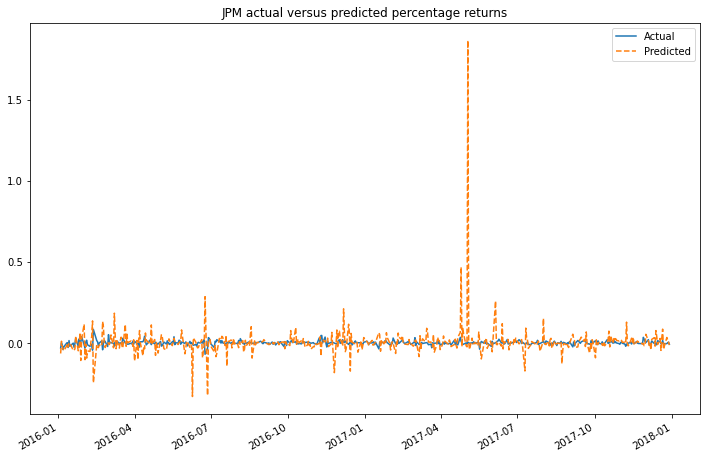

In [ ]:
multi_linear_model.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

In [ ]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.036816126050694106
mean_squared_error: 0.010167076209608375
explained_variance_score: -57.90955109726605
r2_score: -58.04109867977755


## An ensemble of decision trees

### Bagging regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  

In [ ]:
bagging = BaggingRegressorModel()
bagging.learn(df_lagged, y, start_date='2016', 
              end_date='2017', lookback_period=10)

In [ ]:
print_regression_metrics(bagging.df_result)

mean_absolute_error: 0.010730097319679057
mean_squared_error: 0.00023009008542165823
explained_variance_score: -0.33612978841629504
r2_score: -0.3361532026070886


Very good compare to linear model

# Predicting trends with classification-based machine learning

## ---Preparing the dataset of multiple assets as input variables

In [ ]:
y = jpm_prices.pct_change().dropna()
y_direction = y >= 0

Our target variables consist of
Boolean indicators, where a True value indicates an increase or
no-change from the previous trading day's closing price, and a
False value indicates a decrease.

In [ ]:
y_direction.head(3)

1980-03-18     True
1980-03-19     True
1980-03-20    False
Name: adjclose, dtype: bool

In [ ]:
flags = list(y_direction.unique())
flags.sort()

In [ ]:
print(flags)

[False, True]


In [ ]:
df_input = df_assets_1m.join(df_assets_3m).dropna()
df_input

,SPX_1m,GLD_1m,UUP_1m,IEF_1m,SPX_3m,GLD_3m,UUP_3m,IEF_3m
2007-05-25,-0.070192,-0.038780,0.015077,-0.008200,-0.908803,-0.013370,-0.002403,-0.008765
2007-05-29,-0.154479,-0.030109,0.017558,-0.014538,-0.906634,0.021347,-0.001602,-0.014020
2007-05-30,-0.101718,-0.029540,0.012987,-0.013622,-0.884803,0.028444,-0.006369,-0.013645
2007-05-31,0.000000,-0.016802,0.010543,-0.012793,-0.883521,0.021668,-0.007171,-0.012707
2007-06-01,0.067979,-0.015558,0.009721,-0.015977,-0.894356,0.033281,-0.002800,-0.018724
...,...,...,...,...,...,...,...,...
2018-01-24,0.222222,0.065239,-0.040791,-0.011329,0.833333,0.070639,-0.053536,-0.011173
2018-01-25,0.222222,0.050916,-0.038763,-0.009517,0.375000,0.058478,-0.054621,-0.012166
2018-01-26,0.428571,0.047779,-0.038843,-0.016678,0.250000,0.057294,-0.052039,-0.018631
2018-01-29,0.111111,0.036630,-0.033568,-0.017932,0.250000,0.055358,-0.050367,-0.020445


In [ ]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2672 entries, 2007-05-25 to 2018-01-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX_1m  2672 non-null   float64
 1   GLD_1m  2672 non-null   float64
 2   UUP_1m  2672 non-null   float64
 3   IEF_1m  2672 non-null   float64
 4   SPX_3m  2672 non-null   float64
 5   GLD_3m  2672 non-null   float64
 6   UUP_3m  2672 non-null   float64
 7   IEF_3m  2672 non-null   float64
dtypes: float64(8)
memory usage: 187.9 KB


## Logistic regression

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')

In [ ]:
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2016', 
                         end_date='2017', lookback_period=100)

In [ ]:
logistic_reg_model.df_result.head()

,Actual,Predicted
2016-01-04,False,True
2016-01-05,True,True
2016-01-06,False,True
2016-01-07,False,True
2016-01-08,False,True


### Risk metrics for measuring classification-based predictions

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

df_result = logistic_reg_model.df_result    
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

matrix = confusion_matrix(actual, predicted)

In [ ]:
print(matrix)

[[103 138]
 [110 152]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


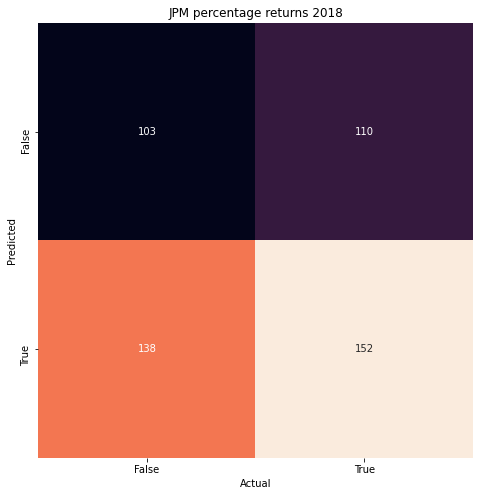

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM percentage returns 2018');

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.48      0.43      0.45       241
        True       0.52      0.58      0.55       262

    accuracy                           0.51       503
   macro avg       0.50      0.50      0.50       503
weighted avg       0.50      0.51      0.50       503



### Accuracy score

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy_score:', accuracy_score(actual, predicted))

accuracy_score: 0.5069582504970179


### Precision score

In [ ]:
from sklearn.metrics import precision_score
print('precision_score:', precision_score(actual, predicted))

precision_score: 0.5241379310344828


### Recall score

In [ ]:
from sklearn.metrics import recall_score
print('recall_score:', recall_score(actual, predicted))

recall_score: 0.5801526717557252


### F1 Score

In [ ]:
from sklearn.metrics import f1_score
print('f1_score:', f1_score(actual, predicted))

f1_score: 0.5507246376811594


## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=0.001, gamma='auto') #C=1000

In [ ]:
svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2018', 
                end_date='2019', lookback_period=100)

In [ ]:
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted))
print('recall_score:', recall_score(actual, predicted))
print('f1_score:', f1_score(actual, predicted))    

accuracy_score: 0.65
precision_score: 0.6842105263157895
recall_score: 0.9285714285714286
f1_score: 0.7878787878787878


In [ ]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.68      0.93      0.79        14

    accuracy                           0.65        20
   macro avg       0.34      0.46      0.39        20
weighted avg       0.48      0.65      0.55        20



## --Check all classification method

In [ ]:
from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score 
from sklearn.pipeline import Pipeline


#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Special
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
class KNeighborsClassifier_Model(LinearRegressionModel):
    def get_model(self):
        return KNeighborsClassifier()

model = KNeighborsClassifier_Model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.50      0.49      0.49       241
        True       0.54      0.55      0.54       262

    accuracy                           0.52       503
   macro avg       0.52      0.52      0.52       503
weighted avg       0.52      0.52      0.52       503



In [ ]:
class SVCModel(LinearRegressionModel):
    def get_model(self):
        return SVC(gamma=0.001) #C=1000

svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.48      0.39      0.43       241
        True       0.52      0.62      0.57       262

    accuracy                           0.51       503
   macro avg       0.50      0.50      0.50       503
weighted avg       0.51      0.51      0.50       503



In [ ]:
class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression()

model = LogisticRegressionModel()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.48      0.43      0.45       241
        True       0.52      0.58      0.55       262

    accuracy                           0.51       503
   macro avg       0.50      0.50      0.50       503
weighted avg       0.50      0.51      0.50       503



In [ ]:
class LinearDiscriminantAnalysisModel(LinearRegressionModel):
    def get_model(self):
        return LinearDiscriminantAnalysis()

model = LinearDiscriminantAnalysisModel()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.50      0.46      0.48       241
        True       0.54      0.58      0.56       262

    accuracy                           0.52       503
   macro avg       0.52      0.52      0.52       503
weighted avg       0.52      0.52      0.52       503



In [ ]:
class GaussianNB_model(LinearRegressionModel):
    def get_model(self):
        return GaussianNB()

model = GaussianNB_model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.46      0.43      0.45       241
        True       0.51      0.53      0.52       262

    accuracy                           0.49       503
   macro avg       0.48      0.48      0.48       503
weighted avg       0.48      0.49      0.48       503



In [ ]:
class RandomForestClassifier_model(LinearRegressionModel):
    def get_model(self):
        return RandomForestClassifier()

model = RandomForestClassifier_model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.48      0.51      0.50       241
        True       0.52      0.50      0.51       262

    accuracy                           0.50       503
   macro avg       0.50      0.50      0.50       503
weighted avg       0.50      0.50      0.50       503



In [ ]:
class AdaBoostClassifier_model(LinearRegressionModel):
    def get_model(self):
        return AdaBoostClassifier()

model = AdaBoostClassifier_model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.48      0.47      0.48       241
        True       0.52      0.53      0.53       262

    accuracy                           0.50       503
   macro avg       0.50      0.50      0.50       503
weighted avg       0.50      0.50      0.50       503



In [ ]:
class GradientBoostingClassifier_model(LinearRegressionModel):
    def get_model(self):
        return GradientBoostingClassifier()

model = GradientBoostingClassifier_model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.47      0.48      0.48       241
        True       0.52      0.51      0.51       262

    accuracy                           0.50       503
   macro avg       0.49      0.49      0.49       503
weighted avg       0.50      0.50      0.50       503



In [ ]:
class LGBMClassifier_model(LinearRegressionModel):
    def get_model(self):
        return LGBMClassifier()

model = LGBMClassifier_model()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.49      0.54      0.51       241
        True       0.53      0.48      0.50       262

    accuracy                           0.51       503
   macro avg       0.51      0.51      0.51       503
weighted avg       0.51      0.51      0.51       503



# Deep learning

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [ ]:
df_input.shape

(2672, 8)

In [ ]:
class DLmodel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])


    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = Sequential()
        model.add(Dense(50, activation='relu', input_dim=df.shape[1]))
        model.add(Dense(10))
        model.add(Dense(1))
        model.compile(optimizer='Adam', loss='binary_crossentropy')

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            # Fitting to the training set
            callbacks = [EarlyStopping(monitor="val_auc", patience=3, 
                                      mode='min',restore_best_weights=True),
                        ModelCheckpoint(filepath="best_model.h5",monitor="val_auc",
                                        save_best_only=True)
                        ]

            model.fit(x, y.ravel(),epochs=50,batch_size=30,
              validation_split=0.2,callbacks=callbacks)

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
model = DLmodel()
model.learn(df_input, y_direction, start_date='2016', 
                end_date='2017', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 0s 1ms/step - loss: 5.8633 - val_loss: 4.8890
Epoch 2/50
80/80 [==============================] - 0s 121us/step - loss: 5.1680 - val_loss: 4.9905
Epoch 3/50
80/80 [==============================] - 0s 90us/step - loss: 4.8360 - val_loss: 4.0130
Epoch 4/50
80/80 [==============================] - 0s 101us/step - loss: 4.7174 - val_loss: 2.4180
Epoch 5/50
80/80 [==============================] - 0s 89us/step - loss: 4.5246 - val_loss: 3.2810
Epoch 6/50
80/80 [==============================] - 0s 86us/step - loss: 4.4666 - val_loss: 2.2116
Epoch 7/50
80/80 [==============================] - 0s 90us/step - loss: 4.0107 - val_loss: 1.8667
Epoch 8/50
80/80 [==============================] - 0s 94us/step - loss: 3.5153 - val_loss: 1.6803
Epoch 9/50
80/80 [==============================] - 0s 87us/step - loss: 2.8092 - val_loss: 1.0287
Epoch 10/50
80/80 [==============================] - 0s 108us/st

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_auc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 23/50
80/80 [==============================] - 0s 139us/step - loss: 0.7347 - val_loss: 0.7315
Epoch 24/50
80/80 [==============================] - 0s 135us/step - loss: 0.7316 - val_loss: 0.7320
Epoch 25/50
80/80 [==============================] - 0s 237us/step - loss: 0.7253 - val_loss: 0.7311
Epoch 26/50
80/80 [==============================] - 0s 121us/step - loss: 0.7223 - val_loss: 0.7307
Epoch 27/50
80/80 [==============================] - 0s 163us/step - loss: 0.7185 - val_loss: 0.7294
Epoch 28/50
80/80 [==============================] - 0s 121us/step - loss: 0.7155 - val_loss: 0.7288
Epoch 29/50
80/80 [==============================] - 0s 121us/step - loss: 0.7127 - val_loss: 0.7292
Epoch 30/50
80/80 [==============================] - 0s 145us/step - loss: 0.7105 - val_loss: 0.7301
Epoch 31/50
80/80 [==============================] - 0s 127us/step - loss: 0.7089 - val_loss: 0.7324
Epoch 32/50
80/80 [==============================] - 0s 118us/step - loss: 0.7059 - val_los

ValueError: ignored